In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda
import torch.optim as optim
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.nn.functional import relu
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from AE import *

In [2]:
TRAIN_FULL_SKELETONS_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/train_full_skeleton/"
VAL_FULL_SKELETONS_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/val_full_skeleton/"

TRAIN_ALL_SKELETONS_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/train_all/"
VAL_ALL_SKELETONS_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/val_all/"

SAVING_PATH_FULL = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/models/full/"
SAVING_PATH_ALL = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/models/all/"

In [3]:
class CONV_AE(nn.Module):
    def __init__(self):
        super(CONV_AE, self).__init__()
        # Måske gøre brug af batch normalization nogle steder?
        self.encoder = nn.Sequential(
            nn.Conv2d(256, 192, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 128, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 64, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True) # """  MANGLER OGSÅ LINEAR
        )

        self.bottleneck = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(inplace = True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.ConvTranspose2d(128, 192, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.ConvTranspose2d(192, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True)
        )

        # Initialize weights
        self.init_params()
        
    def init_params(self):
        for p in self.parameters():
            if (len(p.shape) > 1):
                nn.init.xavier_normal_(p)

    def encode(self, X):
        X = self.encoder(X)
        X = X.view(X.shape[0], -1)

        X = self.bottleneck(X)
        X = X.view(X.shape[0], 64, 4, 4)

        return X

    def decode(self, X):
        return self.decoder(X)

    def add_noise(self, X, fac = 1):
        noise = torch.randn_like(X) * fac
        return X + noise

    def forward(self, X, add_noise = True):

        if (add_noise):
            X = self.add_noise(X)
        
        X_encoded = self.encode(X)

        X_decoded = self.decode(X_encoded)
        return X_encoded, X_decoded

In [7]:
LEARNING_RATE = 5e-4
NUM_EPOCHS = 500
MINI_BATCH_SIZE = 16
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AE = CONV_AE().to(device)
optimizer = optim.SGD(AE.parameters(), lr = LEARNING_RATE, momentum = 0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience=10, mode = "min", verbose=True)

In [8]:
class dataset(Dataset):
    def __init__(self, PATH):
        self.path = PATH
        self.data = os.listdir(self.path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return np.load(self.path + self.data[i])

train_dataset_full = dataset(TRAIN_FULL_SKELETONS_PATH)
train_dataloader_full = DataLoader(train_dataset_full, batch_size = MINI_BATCH_SIZE)
val_dataset_full = dataset(VAL_FULL_SKELETONS_PATH)
val_dataloader_full = DataLoader(val_dataset_full, batch_size = 1)

train_dataset_all = dataset(TRAIN_ALL_SKELETONS_PATH)
train_dataloader_all = DataLoader(train_dataset_all, batch_size = MINI_BATCH_SIZE)
val_dataset_all = dataset(VAL_ALL_SKELETONS_PATH)
val_dataloader_all = DataLoader(val_dataset_all, batch_size = 1)

In [10]:
""" FITTING ON FULL SKELETONS """

torch.cuda.empty_cache()
#train_losses = []
#val_losses = []

for epoch in tqdm(range(NUM_EPOCHS), desc = "EPOCH"):
    AE.train()
    print("Epoch:", epoch)
    train_losses.append(0)
    for x in train_dataloader_full:

        # Prework
        x = x.to(device, dtype = torch.float)

        # Prediction
        _, decoded = AE(x)

        # Backpropegation
        optimizer.zero_grad()

        # Train loss
        train_loss = criterion(decoded, x)
        train_losses[-1] += train_loss.item()

        # Backpropegation
        train_loss.backward()
        optimizer.step()

    train_losses[-1] /= len(train_dataloader_full)
    print("     Train loss:", train_losses[-1])

    # Validation
    with torch.no_grad():
        AE.eval()
        val_losses.append(0)
        #for x_val in tqdm(X_val, desc = "Validation", leave = False):
        for x_val in val_dataloader_full:

            # Prework
            x_val = x_val.to(device, dtype = torch.float)

            # Prediction
            _, decoded = AE(x_val, add_noise = False)

            # Validation loss
            val_loss = criterion(decoded, x_val)
            val_losses[-1] += val_loss.item()

    val_losses[-1] /= len(val_dataloader_full)

    scheduler.step(val_losses[-1])
    
    print("     Validation loss:", val_losses[-1])

Epoch: 0
     Train loss: 13.504086607409501
     Validation loss: 12.782763847613925
Epoch: 1
     Train loss: 13.502890659627719
     Validation loss: 12.78159219131874
Epoch: 2
     Train loss: 13.501578172409996
     Validation loss: 12.779809635856548
Epoch: 3
     Train loss: 13.500099022459061
     Validation loss: 12.781321012089194
Epoch: 4
     Train loss: 13.498935098800137
     Validation loss: 12.779232335596118
Epoch: 5
     Train loss: 13.497622917887833
     Validation loss: 12.778622104927845
Epoch: 6
     Train loss: 13.496324790094327
     Validation loss: 12.774995983700027
Epoch: 7
     Train loss: 13.494791953058613
     Validation loss: 12.77552365666986
Epoch: 8
     Train loss: 13.49344486853528
     Validation loss: 12.773100449423907
Epoch: 9
     Train loss: 13.491606973026771
     Validation loss: 12.770542857503722
Epoch: 10
     Train loss: 13.490131195694005
     Validation loss: 12.768935164798696
Epoch: 11
     Train loss: 13.488968811165499
     Valid

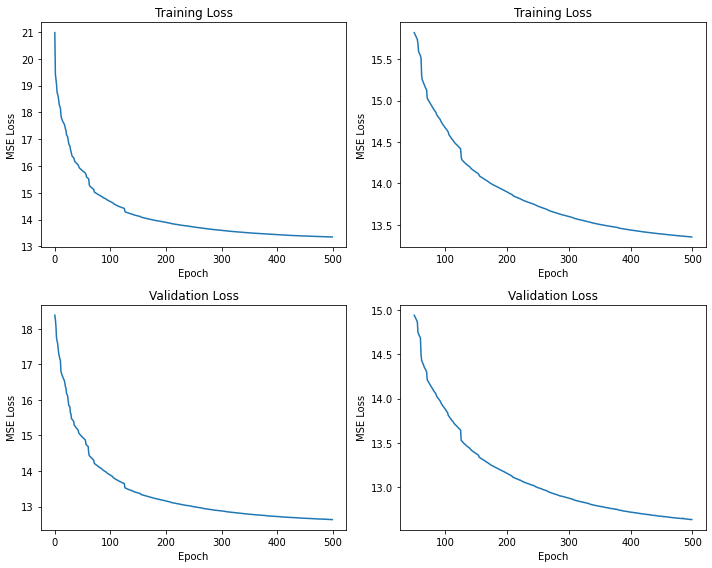

In [11]:
fig, axs = plt.subplots(2, 2, figsize = (10, 8))
n = 50

axs[0, 0].plot(np.arange(0, len(train_losses)), train_losses)
axs[0, 0].set_ylabel("MSE Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_title("Training Loss")

axs[0, 1].plot(np.arange(n, len(train_losses)), train_losses[n:])
axs[0, 1].set_ylabel("MSE Loss")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_title("Training Loss")

axs[1, 0].plot(np.arange(0, len(val_losses)), val_losses)
axs[1, 0].set_ylabel("MSE Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_title("Validation Loss")

axs[1, 1].plot(np.arange(n, len(val_losses)), val_losses[n:])
axs[1, 1].set_ylabel("MSE Loss")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_title("Validation Loss")

plt.tight_layout()
plt.show()

In [12]:
np.save(SAVING_PATH_FULL + "val_loss.npy", val_losses)
np.save(SAVING_PATH_FULL + "train_loss.npy", train_losses)
torch.save(AE.state_dict(), SAVING_PATH_FULL + "model.pth")
torch.save(optimizer.state_dict(), SAVING_PATH_FULL + "optimizer.pth")
torch.save(scheduler.state_dict(), SAVING_PATH_FULL + "scheduler.pth")

In [6]:
LEARNING_RATE = 5e-4
NUM_EPOCHS = 100
MINI_BATCH_SIZE = 16
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AE = CONV_AE().to(device)
optimizer = optim.SGD(AE.parameters(), lr = LEARNING_RATE, momentum = 0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience=10, mode = "min", verbose=True)

In [12]:
""" FITTING ON ALL SKELETONS """

torch.cuda.empty_cache()
#train_losses = []
#val_losses = []

for epoch in tqdm(range(NUM_EPOCHS), desc = "EPOCH"):
    AE.train()
    print("Epoch:", epoch)
    train_losses = np.append(train_losses, 0)
    for x in tqdm(train_dataloader_all, desc = "TRAINING", leave = False, total = len(train_dataloader_all)):

        # Prework
        x = x.to(device, dtype = torch.float)

        # Prediction
        _, decoded = AE(x)

        # Backpropegation
        optimizer.zero_grad()

        # Train loss
        train_loss = criterion(decoded, x)
        train_losses[-1] += train_loss.item()

        # Backpropegation
        train_loss.backward()
        optimizer.step()

    train_losses[-1] /= len(train_dataloader_all)
    print("     Train loss:", train_losses[-1])

    # Validation
    with torch.no_grad():
        AE.eval()
        val_losses = np.append(val_losses, 0)
        #for x_val in tqdm(X_val, desc = "Validation", leave = False):
        for x_val in tqdm(val_dataloader_all, desc = "VALIDATING", leave = False, total = len(val_dataloader_all)):

            # Prework
            x_val = x_val.to(device, dtype = torch.float)

            # Prediction
            _, decoded = AE(x_val, add_noise = False)

            # Validation loss
            val_loss = criterion(decoded, x_val)
            val_losses[-1] += val_loss.item()

    val_losses[-1] /= len(val_dataloader_all)

    scheduler.step(val_losses[-1])
    
    print("     Validation loss:", val_losses[-1])

Epoch: 0


     Train loss: 6.304105433559135


     Validation loss: 5.745648178820738
Epoch: 1


     Train loss: 6.303813936786314


     Validation loss: 5.745470753048457
Epoch: 2


     Train loss: 6.303527678395339


     Validation loss: 5.744215301733823
Epoch: 3


     Train loss: 6.3032618208606825


     Validation loss: 5.746500763118173
Epoch: 4


     Train loss: 6.303003823451191


     Validation loss: 5.746059277399456
Epoch: 5


     Train loss: 6.30275220497645


     Validation loss: 5.747024167276106
Epoch: 6


     Train loss: 6.302504191318051


     Validation loss: 5.743472862229528
Epoch: 7


     Train loss: 6.302207186654754


     Validation loss: 5.743625333971133
Epoch: 8


     Train loss: 6.302014666804188


     Validation loss: 5.743592643977906
Epoch: 9


     Train loss: 6.301736257713748


     Validation loss: 5.742067443863099
Epoch: 10


KeyboardInterrupt: 

In [ ]:
"""
* 53
"""

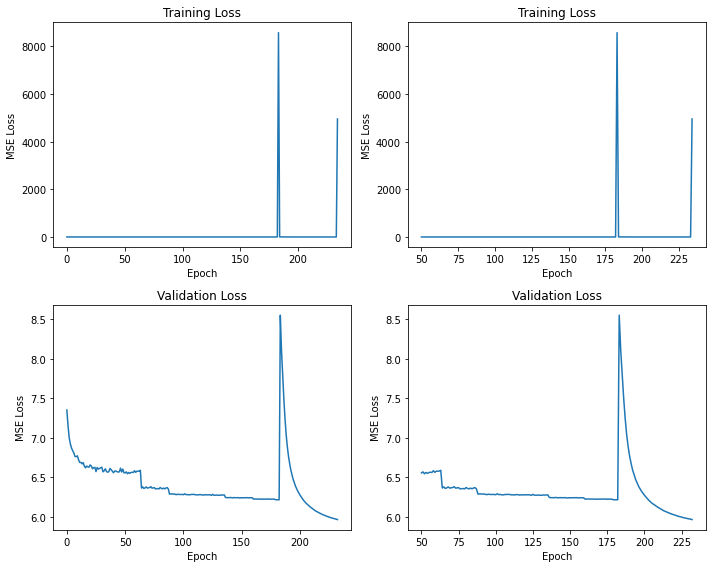

In [16]:
fig, axs = plt.subplots(2, 2, figsize = (10, 8))
n = 50

axs[0, 0].plot(np.arange(0, len(train_losses)), train_losses)
axs[0, 0].set_ylabel("MSE Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_title("Training Loss")

axs[0, 1].plot(np.arange(n, len(train_losses)), train_losses[n:])
axs[0, 1].set_ylabel("MSE Loss")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_title("Training Loss")

axs[1, 0].plot(np.arange(0, len(val_losses)), val_losses)
axs[1, 0].set_ylabel("MSE Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_title("Validation Loss")

axs[1, 1].plot(np.arange(n, len(val_losses)), val_losses[n:])
axs[1, 1].set_ylabel("MSE Loss")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_title("Validation Loss")

plt.tight_layout()
plt.show()

In [13]:
np.save(SAVING_PATH_ALL  + "val_loss.npy", val_losses)
np.save(SAVING_PATH_ALL + "train_loss.npy", train_losses)
torch.save(AE.state_dict(), SAVING_PATH_ALL + "model.pth")
torch.save(optimizer.state_dict(), SAVING_PATH_ALL + "optimizer.pth")
torch.save(scheduler.state_dict(), SAVING_PATH_ALL + "scheduler.pth")

In [9]:
val_losses = np.load(SAVING_PATH_ALL  + "val_loss.npy")
train_losses = np.load(SAVING_PATH_ALL + "train_loss.npy")
AE.load_state_dict(torch.load(SAVING_PATH_ALL + "model.pth"))
optimizer.load_state_dict(torch.load(SAVING_PATH_ALL + "optimizer.pth"))
scheduler.load_state_dict(torch.load(SAVING_PATH_ALL + "scheduler.pth"))